# B jet study

In [2]:
%cd ..

/global/home/users/yifengh3/EMD_VAE


In [3]:
import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

import tensorflow.keras as keras
import tensorflow.keras.backend as K

import os
import os.path as osp
import sys

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

from utils.tf_sinkhorn import ground_distance_tf_nograd, sinkhorn_knopp_tf_scaling_stabilized_class
import utils.VAE_model_tools
from utils.VAE_model_tools import build_and_compile_annealing_vae, betaVAEModel, reset_metrics

import pandas
import matplotlib.pyplot as plt

import h5py
import pickle
from scipy.stats import gaussian_kde

1 Physical GPUs, 0 Logical GPUs
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
INFO:tensorflow:Using MirroredStrategy with devices ('/device:CPU:0',)
INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:CPU:0',), communication = CommunicationImplementation.AUTO


In [29]:
def create_dir(dir_path):
    ''' Creates a directory (or nested directories) if they don't exist.
    '''
    if not osp.exists(dir_path):
        os.makedirs(dir_path)

    return dir_path

output_dir = './data/'
    
def kl_loss(z_mean, z_log_var):
    return -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    
    
from pyjet import cluster

def get_clustered_pt_eta_phi(pts, locations,R=0.1):
    weights = pts
    outjet = locations
    myjet = np.zeros((weights.shape[-1]),dtype=([('pT', 'f8'), ('eta', 'f8'), ('phi', 'f8'), ('mass', 'f8')]))
    myjet['pT'] = weights
    myjet['eta'] = outjet[:,0]
    myjet['phi'] = outjet[:,1]
    sequence = cluster(myjet,R=R,p=0)
    jets = sequence.inclusive_jets()
    phis = np.array([np.mod(np.pi+jet.phi,2*np.pi)-np.pi for jet in jets])
    etas = np.array([jet.eta for jet in jets])
    pts = np.array([jet.pt for jet in jets])
    
    return pts, etas, phis


def plot_jets(outs_array, numplot = 3, R=0.02,size=50, save_dir = None):
    etalim=5
    #bins=np.linspace(-lim, lim, 126)

    for i in range(numplot):   

        fig, ax = plt.subplots(1, 3,figsize=[15,5],sharey=True)



        outjet = valid_y[i,:,1:]
        weights = valid_y[i,:,0]
        pts, etas, phis = get_clustered_pt_eta_phi(weights, outjet,R=R)
        ax[0].scatter(phis, etas, s = pts*size, alpha = 0.7,linewidths=0)
        ax[0].set_title('Jet'+str(i),y=0.9)

        #ax[0].hist2d(feed_pc[i][:,0],feed_pc[i][:,1],range=[[-lim,lim],[-lim,lim]],bins=bins, norm=LogNorm(0.5, 1000))
        for j in range(2):
            outjet = outs_array[j][0][i,:,1:]
            weights = outs_array[j][0][i,:,0]
            pts, etas, phis = get_clustered_pt_eta_phi(weights, outjet,R=R)
            ax[j+1].scatter(phis, etas, s = pts*size, alpha = 0.7,linewidths=0)
            ax[j+1].set_title('Sample'+ str(j),y=0.9)
            
        for j in range(3):
            ax[j].set_ylabel(r'$\eta$',fontsize=18)
            ax[j].set_xlabel(r'$\phi$',fontsize=18)
            ax[j].set_ylim([-5,5])
            ax[j].set_xlim([-np.pi,np.pi])

        plt.subplots_adjust(wspace=0, hspace=0)
        if save_dir:
            outfile = os.path.join(save_dir,"jets_plot_{}.png".format(i))
            plt.savefig(outfile)
        plt.show()
        
def plot_KL_logvar(outs_array,xlim=None,ylim=None):
    
    _, z_mean, z_log_var, z = outs_array[0]

    KL=kl_loss(z_mean, z_log_var)
    sort_kl = np.flip(np.argsort(np.mean(KL,axis=0)))

    rms_mean = np.sqrt(np.mean(np.square(z_mean),axis=0))

    plt.scatter(np.mean(KL,axis=0),rms_mean,s=5.)

    if ylim:
        plt.ylim(ylim)
    if xlim:
        plt.xlim(xlim)
        
    plt.xlabel('KL divergence')
    plt.ylabel(r'$\sqrt{\left\langle \mu^2 \right\rangle}$')
    plt.show()
    
    return sort_kl

def get_plot(file, save_dir = None):
    vae.load_weights(file)
    beta = get_beta(file)
    outs_array = [vae.predict(valid_x[:1000]) for j in range(3)]
    output_dir = None
    
    if save_dir:
        output_dir = os.path.join(save_dir,"epoch{}_beta{}".format(get_epoch(file),get_beta(file)))
        create_dir(output_dir)
    
    vae.beta.assign(beta)
    result = vae.test_step([valid_x[:2000].astype(np.float32),valid_y[:2000].astype(np.float32)])
    
    print("epoch = {}".format(get_epoch(file)))
    print("Beta = {}".format(beta))
    print("Loss:", "{:.02e}".format(result['loss'].numpy()))
    print("Recon loss:", "{:.02e}".format(result['recon_loss'].numpy()))
    print("KL loss:", result['KL loss'].numpy())

    print()

    print("KL divergences plot. x axis is ~ log(resolution) for resolution << 1")
    sort_kl = plot_KL_logvar(outs_array,[-0.1,None],[-0.1,None])

    print("Jet sample plots. Left = original jet. Middle and right: two vae samples")
    plot_jets(outs_array,R=0.05,size=1000,save_dir=output_dir)

    print("Latent space distributions in most important latent space directions")
    _, z_mean, z_log_var, z = outs_array[0]

    plt.scatter(z_mean[:,sort_kl[0]],z_mean[:,sort_kl[1]],s=1.)
    plt.xlabel(r'$\sqrt{\left\langle \mu_0^2 \right\rangle}$')
    plt.ylabel(r'$\sqrt{\left\langle \mu_1^2 \right\rangle}$')
    plt.show()
    plt.scatter(z_mean[:,sort_kl[2]],z_mean[:,sort_kl[3]],s=1.)
    plt.xlabel(r'$\sqrt{\left\langle \mu_2^2 \right\rangle}$')
    plt.ylabel(r'$\sqrt{\left\langle \mu_3^2 \right\rangle}$')
    plt.show()

    plt.scatter(z_mean[:,sort_kl[0]],z_log_var[:,sort_kl[0]],s=1.)
    plt.xlabel(r'$\sqrt{\left\langle \mu_0^2 \right\rangle}$')
    plt.ylabel(r'$\left\langle \log \sigma_0 \right\rangle$')
    plt.show()
    plt.scatter(z_mean[:,sort_kl[1]],z_log_var[:,sort_kl[1]],s=1.)
    plt.xlabel(r'$\sqrt{\left\langle \mu_1^2 \right\rangle}$')
    plt.ylabel(r'$\left\langle \log \sigma_1 \right\rangle$')
    plt.show()

#     print("Investigation of first two latent directions. Salmon is unpopulated regions of the latent space (see scatter plots above).Note that opposite points on the disk are very similar, which reflects the topology of 2-body decays. A two body decay is specified by two coordinates, phi and theta (in the rest frame) or z (in the boosted frame) for one of the particles. This is the sphere S^2 with the phi coordinate determining longitude and z/theta determining latitude (the equator is balanced jets, the poles is maximially unbalanced). If the particles are considered identical, then antipodes are identified (which is the geometry of RP^2). The sphere is a double cover of the decay kinematics (if you know z and phi for particle 1, then you know it also for particle 2). The shape you see below is a projection of a hemisphere of that. The topology of the latent space is R^n, which cannot faithfully reproduce RP^2, but it is trying its best. Jets that are close to eachother in real space correspond to latent points that are close in the latent space, except at the rim of the disk where a small change in real space can take you straight to the opposite edge of the disk. As the resolution of the VAE gets finer and finer, this affects a smaller and smaller annulus of jets around the rim of the disk.")

    narray = 11
    lim = 3.0
    codes = np.zeros((narray**2,128))

    dirs = [0,1]

    for i in range(narray):
        for j in range(narray):
            codes[narray*i+j,sort_kl[dirs[0]]] = (i-(narray-1)/2)*lim/((narray-1)/2)
            codes[narray*i+j,sort_kl[dirs[1]]] = (j-(narray-1)/2)*lim/((narray-1)/2)

    decoded = decoder.predict(codes)

    fig, ax = plt.subplots(narray, narray,figsize=[15,15],sharex=True,sharey=True)

    for i in range(narray):
        for j in range(narray):
            outjet = decoded[narray*i+j,:,1:]
            weights = decoded[narray*i+j,:,0]
            pts, etas, phis = get_clustered_pt_eta_phi(weights, outjet,R=0.05)
            x=codes[narray*i+j,sort_kl[dirs[0]]]
            y=codes[narray*i+j,sort_kl[dirs[1]]]
            if np.square(x) + np.square(y) > np.square(2.7):
                ax[i,j].set_facecolor('xkcd:salmon')
            ax[i,j].scatter(phis, etas, s = pts*1000, alpha = 0.7,linewidths=0)
            ax[i,j].set_xlim(-0.5,0.5)
            ax[i,j].set_ylim(-0.5,0.5)
            ax[i,j].set_title('['+'{:.1f}'.format(x)+','+'{:.1f}'.format(y)+']',
                             y=0.8)
    #         ax[j,i].set_aspect('equal')
    ax[int((narray-1)/2),int((narray-1)/2)].set_facecolor([0.9,0.9,0.9])
    plt.subplots_adjust(wspace=0, hspace=0)
    if save_dir:
        outfile = os.path.join(output_dir,"salmon_plot.png".format(i))
        plt.savefig(outfile)
    plt.show()


def load_weights(file, save_dir = None,xlim=None,ylim=None):
    vae.load_weights(file)
    
    if save_dir:
        create_dir(save_dir)
    
    outs_array = [vae.predict(valid_x[:1000]) for j in range(3)]
    _, z_mean, z_log_var, z = outs_array[0]

    KL=kl_loss(z_mean, z_log_var)
    sort_kl = np.flip(np.argsort(np.mean(KL,axis=0)))

    rms_mean = np.sqrt(np.mean(np.square(z_mean),axis=0))

    plt.scatter(np.mean(KL,axis=0),rms_mean,s=5.)

    if ylim:
        plt.ylim(ylim)
    if xlim:
        plt.xlim(xlim)
        
    plt.xlabel('KL divergence')
    plt.ylabel(r'$\sqrt{\left\langle \mu^2 \right\rangle}$')
    plt.title("epoch = {}, beta = {}".format(get_epoch(file),get_beta(file)))
    if save_dir:
        outfile = os.path.join(save_dir,"KL_plot_{}_{}.png".format(get_epoch(file),get_beta(file)))
        plt.savefig(outfile)
    plt.show()

# Set up model

In [7]:
# path to file
fn =  '/global/home/users/yifengh3/data/B_background.h5'

df = pandas.read_hdf(fn,stop=1000000)
print(df.shape)
print("Memory in GB:",sum(df.memory_usage(deep=True)) / (1024**3)+sum(df.memory_usage(deep=True)) / (1024**3))

# Data file contains, for each event, 50 particles (with zero padding), each particle with pT, eta, phi
data = df.values.reshape((-1,50,3))

# Normalize pTs so that HT = 1
HT = np.sum(data[:,:,0],axis=-1)
data[:,:,0] = data[:,:,0]/HT[:,None]

# Inputs x to NN will be: pT, eta, cos(phi), sin(phi), log E
# Separated phi into cos and sin for continuity around full detector, so make things easier for NN.
# Also adding the log E is mainly because it seems like it should make things easier for NN, since there is an exponential spread in particle energies.
# Feel free to change these choices as desired. E.g. px, py might be equally as good as pt, sin, cos.
sig_input = np.zeros((len(data),50,4))
sig_input[:,:,:2] = data[:,:,:2]
sig_input[:,:,2] = np.cos(data[:,:,2])
sig_input[:,:,3] = np.sin(data[:,:,2])
# no input from energy for B jets
# sig_input[:,:,4] = np.log(data[:,:,3]+1e-8)


data_x = sig_input
# Event 'labels' y are [pT, eta, phi], which is used to calculate EMD to output which is also pT, eta, phi.
data_y = data


train_x = data_x[:800000]
train_y = data_y[:800000]
valid_x = data_x[800000:]
valid_y = data_y[800000:]

(1000000, 150)
Memory in GB: 2.250075340270996


In [8]:
output_dir = '/global/home/users/yifengh3/B_result'
experiment_name = 'B_train_1'
train_output_dir = create_dir(osp.join(output_dir, experiment_name))
vae, encoder, decoder = build_and_compile_annealing_vae(optimizer=keras.optimizers.Adam(lr=0.001,clipnorm=0.1),
                                    encoder_conv_layers = [1024,1024,1028,1024],
                                    dense_size = [1028,1028,1028,512],
                                    decoder = [2048,2048,1028,512,512],
                                    numItermaxinner = 40,   # EMD approximation params
                                    numIter=10,
                                    reg_init = 1.,
                                    reg_final = 0.01,
                                    stopThr=1e-3,
                                    num_inputs=4,           # Size of x (e.g. pT, eta, sin, cos, log E)
                                    num_particles_in=50)    # Num particles per event.

batch_size=100
save_period=2

reduceLR = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=2, verbose=1, mode='auto', min_delta=1e-4, cooldown=0, min_lr=0)
modelcheckpoint = keras.callbacks.ModelCheckpoint(train_output_dir + '/model_weights_{epoch:02d}.hdf5', save_freq = save_period*5000, save_weights_only=True)
reset_metrics_inst = reset_metrics()


# Need to train on at least one example before model params can be loaded for annoying reasons.

history = vae.fit(x=train_x[:10], y=train_y[:10], batch_size=batch_size,
                epochs=1,verbose=1,#initial_epoch=int(vae.optimizer.iterations/numbatches),
                validation_data = (valid_x[:10],valid_y[:10])
)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Model: "VAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 50, 4)]      0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 50, 1024)     5120        inputs[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 50, 1024)     0           conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 50, 1024)     1049600     re_lu[0][0]                      
_________

1/1 [==============================] - 4s 4s/step - loss: 23.2916 - recon_loss: 5.0151 - KL loss: 20.7841 - beta: 1.0000 - val_loss: 18.7124 - val_recon_loss: 4.5583 - val_KL loss: 16.4333 - val_beta: 1.0000


In [9]:
%cd /global/home/users/yifengh3/B_result/B_train_1

/global/home/users/yifengh3/B_result/B_train_1


In [14]:
print("Preparing to load weights")

import glob
import re

def get_epoch(file):
    epoch_string=re.compile('_\d*_')
    epoch = int(epoch_string.search(file).group()[1:-1])
    return epoch

def get_beta(file):
    beta_string=re.compile('\d\.[\w\+-]*')
    beta = float(beta_string.search(file).group())
    return beta

files = glob.glob(train_output_dir + '/model_weights_end*.hdf5')
files.sort(key=os.path.getmtime)
epochs = np.array([get_epoch(file) for file in files])
betas = np.array([get_beta(file) for file in files])

Preparing to load weights


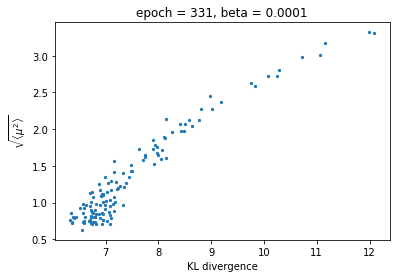

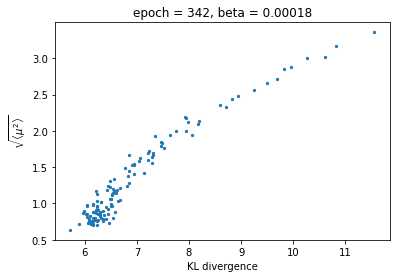

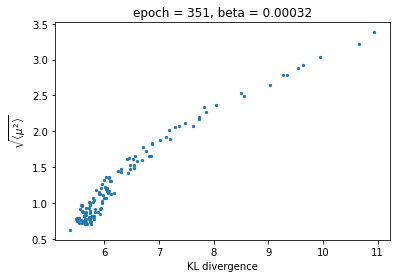

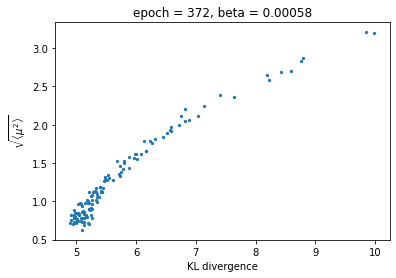

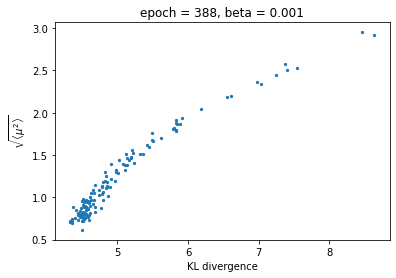

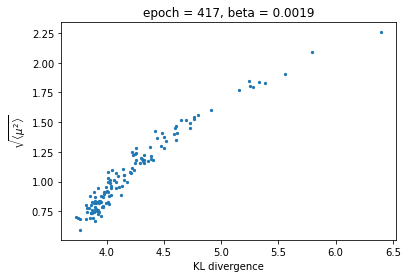

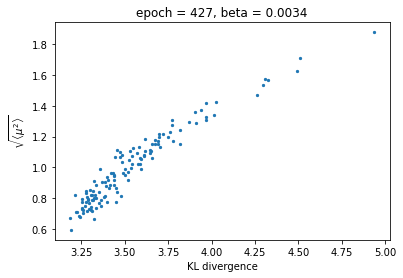

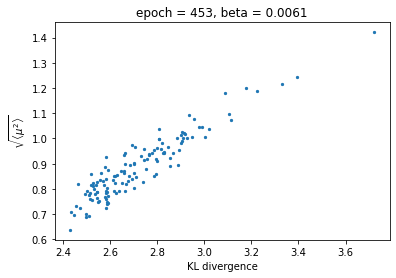

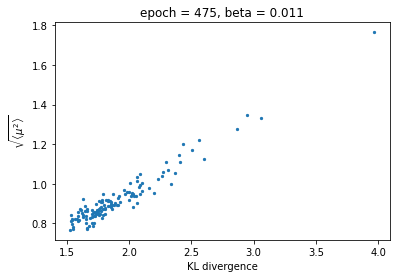

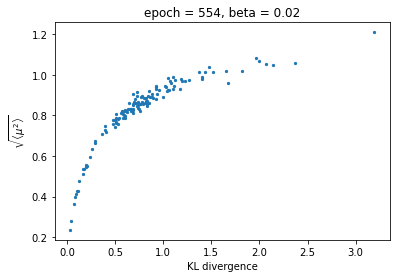

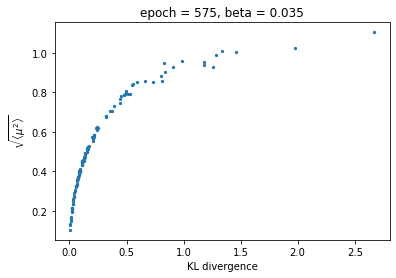

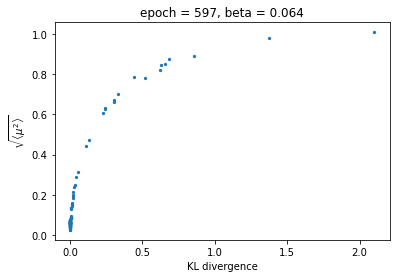

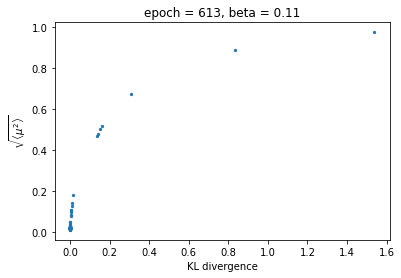

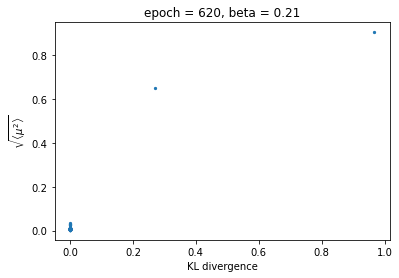

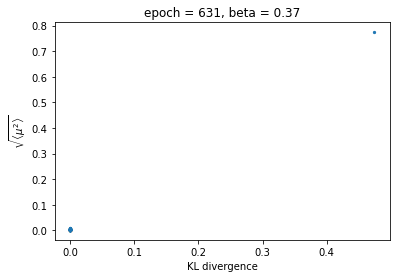

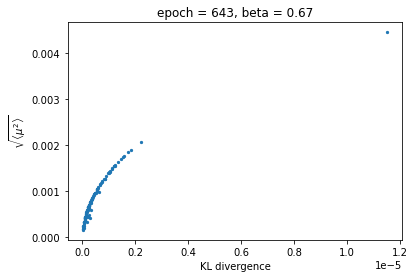

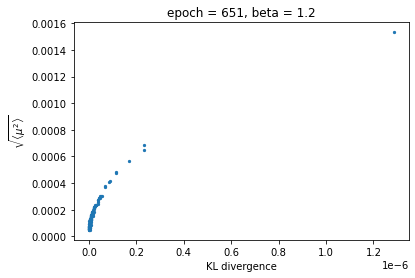

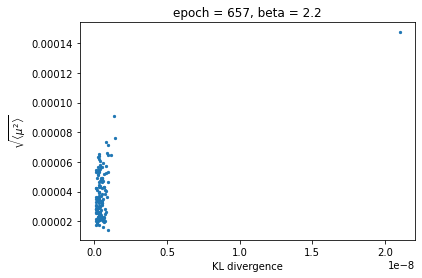

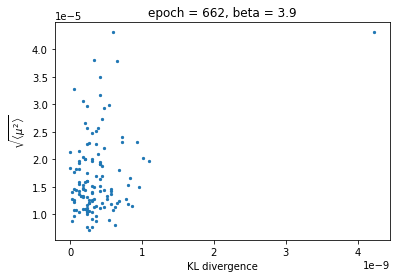

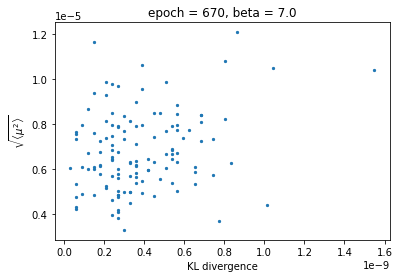

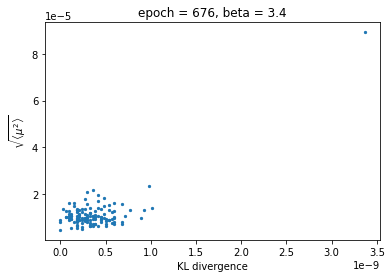

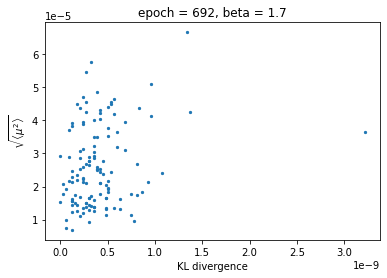

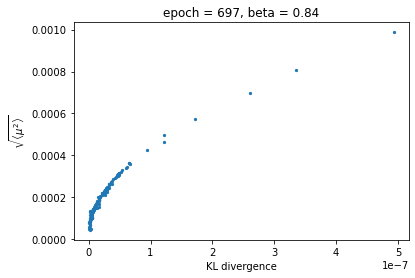

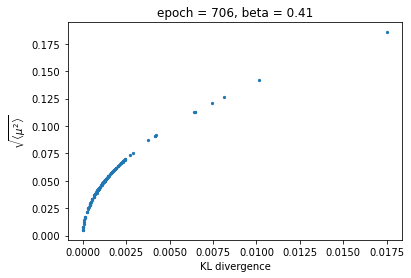

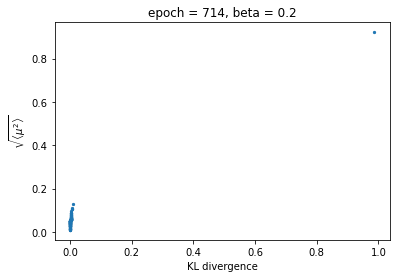

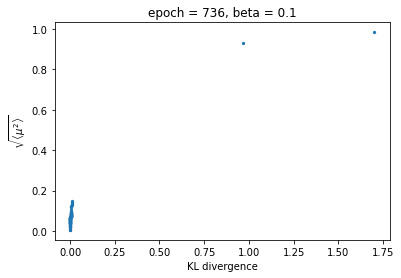

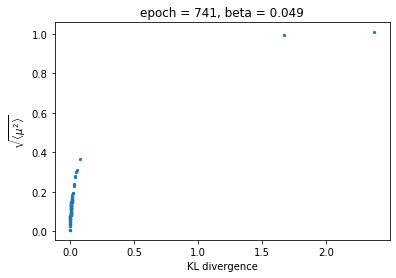

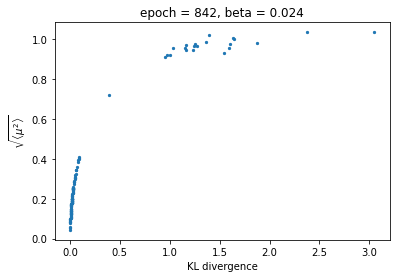

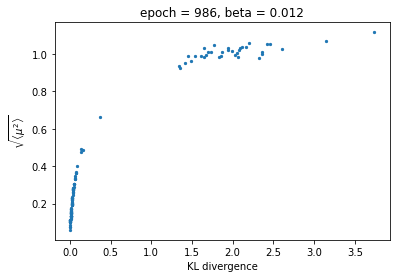

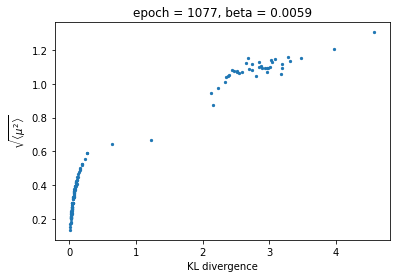

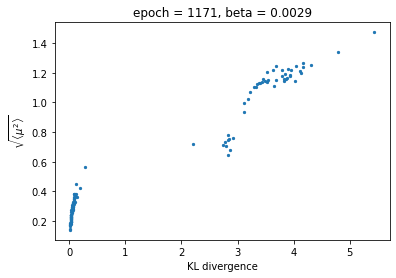

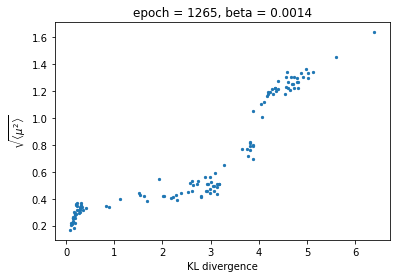

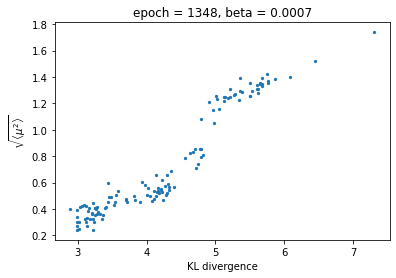

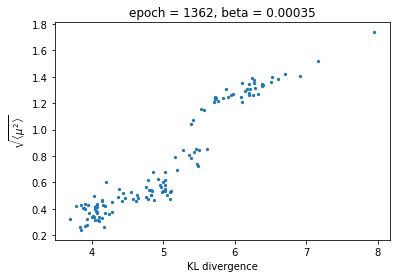

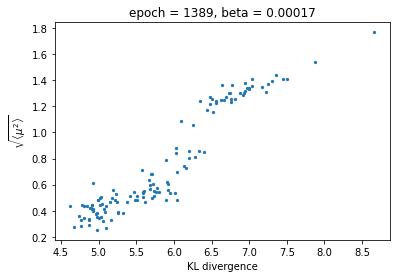

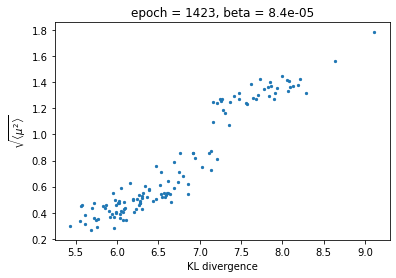

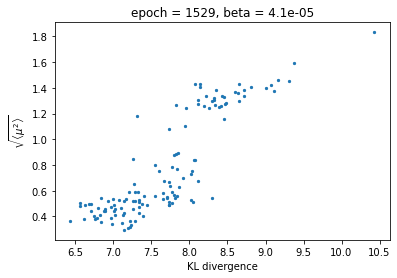

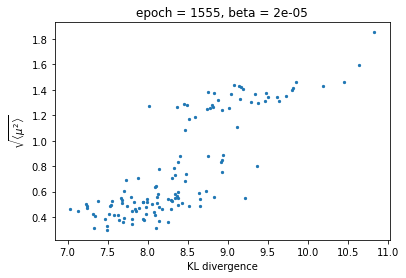

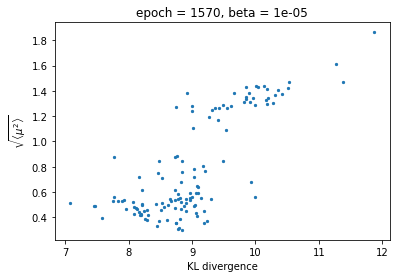

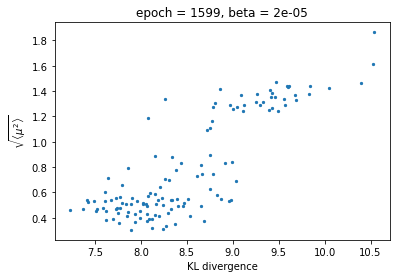

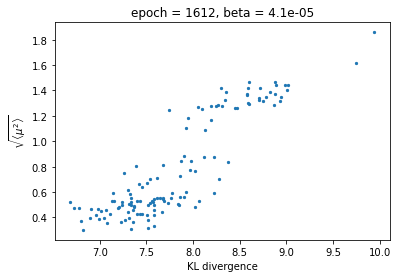

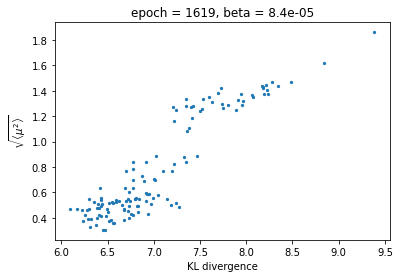

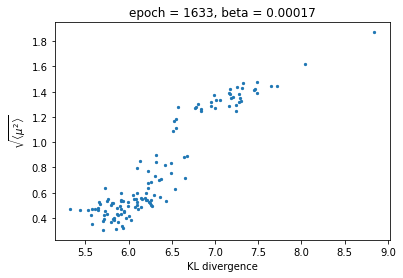

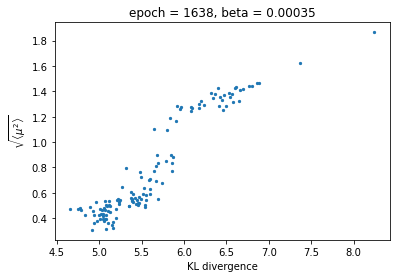

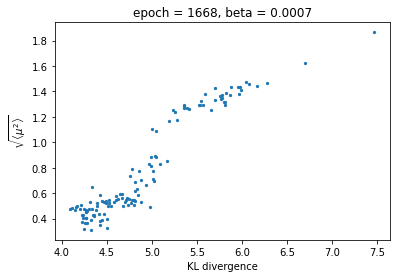

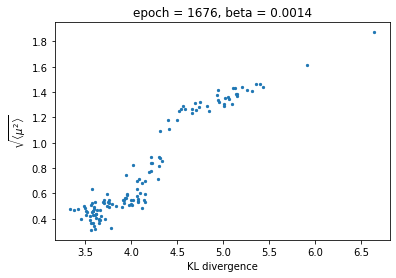

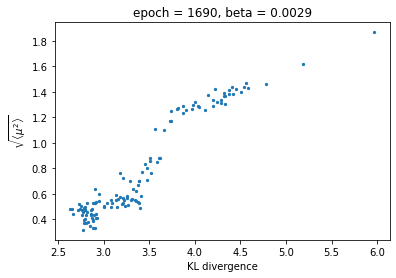

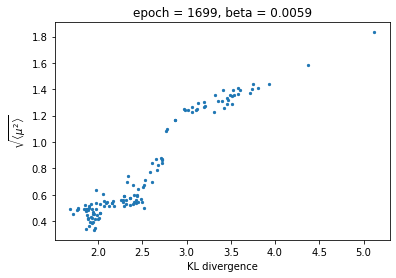

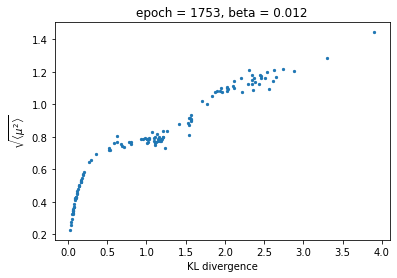

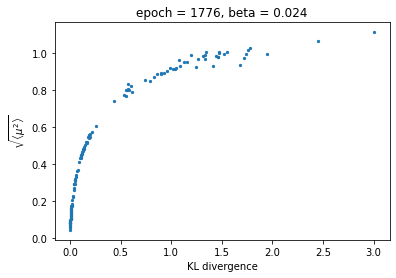

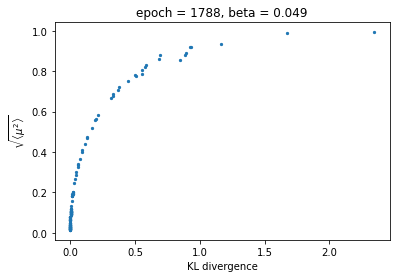

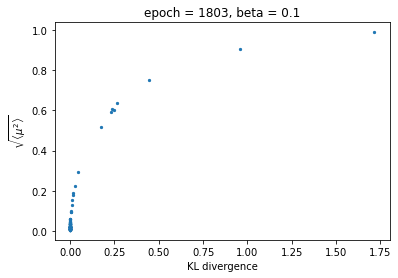

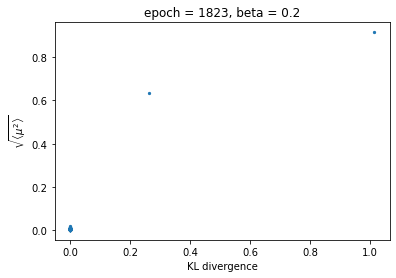

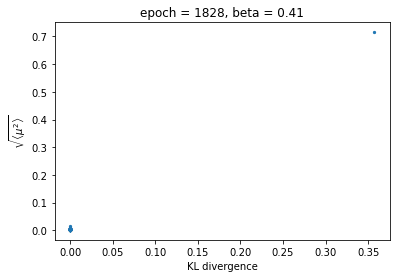

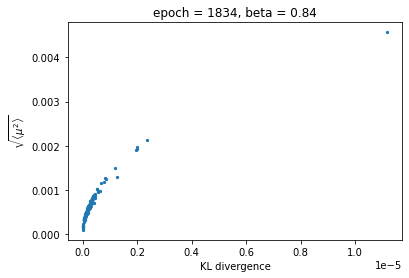

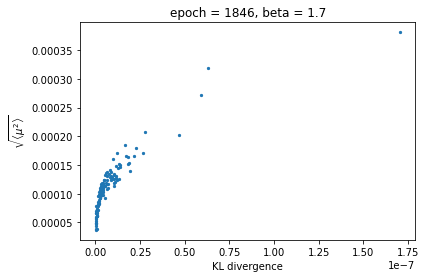

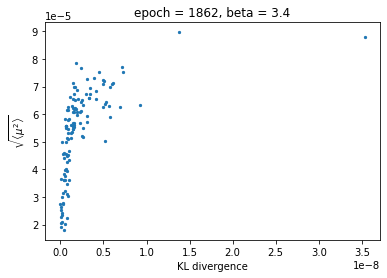

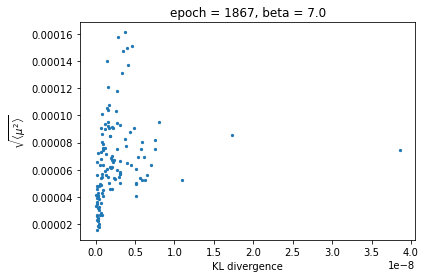

In [64]:
for file in files:
    load_weights(file,"/global/home/users/yifengh3/B_result/B_train_1/weight_summary")

In [9]:
%ls

Ds_0.png                 model_weights_841.hdf5
Ds_1.png                 model_weights_862.hdf5
Ds_2.png                 model_weights_882.hdf5
Ds_all.png               model_weights_902.hdf5
KL.png                   model_weights_922.hdf5
log.csv                  model_weights_942.hdf5
loss.png                 model_weights_962.hdf5
losstimebetasqr.png      model_weights_982.hdf5
model_weights_1006.hdf5  model_weights_end_1077_5.9e-03.hdf5
model_weights_100.hdf5   model_weights_end_1171_2.9e-03.hdf5
model_weights_1026.hdf5  model_weights_end_1265_1.4e-03.hdf5
model_weights_1046.hdf5  model_weights_end_1348_7.0e-04.hdf5
model_weights_1066.hdf5  model_weights_end_1362_3.5e-04.hdf5
model_weights_1097.hdf5  model_weights_end_1389_1.7e-04.hdf5
model_weights_1117.hdf5  model_weights_end_1423_8.4e-05.hdf5
model_weights_1137.hdf5  model_weights_end_1529_4.1e-05.hdf5
model_weights_1157.hdf5  model_weights_end_1555_2.0e-05.hdf5
model_weights_1191.hdf5  model_weights_end_1570_1.0e-05.hdf5
model_

epoch = 620
Beta = 0.21
Loss: 7.33e+00
Recon loss: 5.37e-01
KL loss: 1.2432755

KL divergences plot. x axis is ~ log(resolution) for resolution << 1


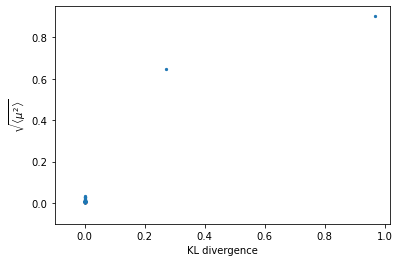

Jet sample plots. Left = original jet. Middle and right: two vae samples


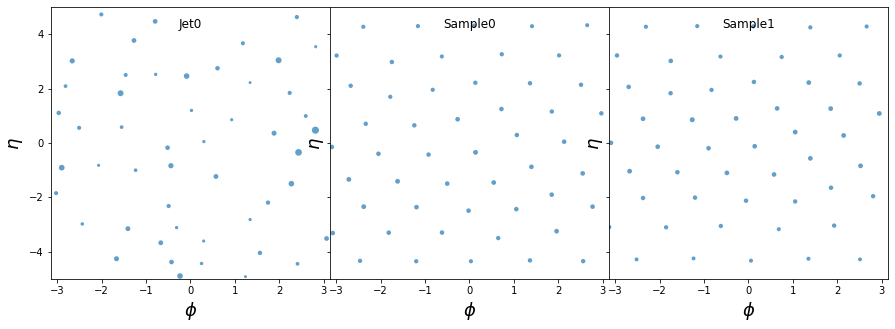

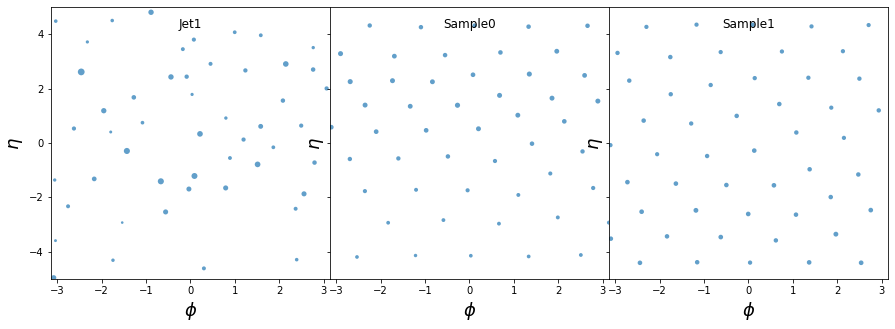

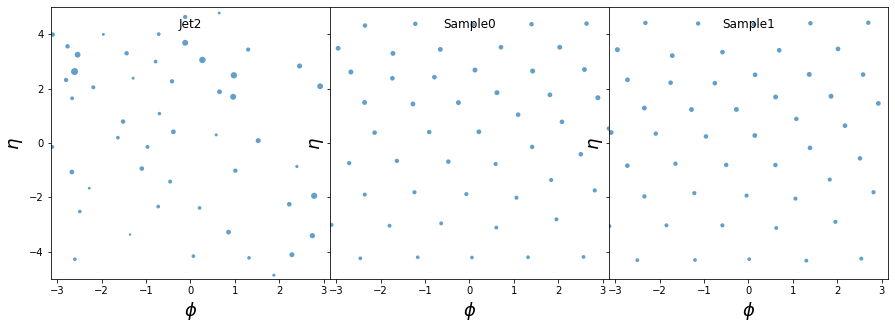

Latent space distributions in most important latent space directions


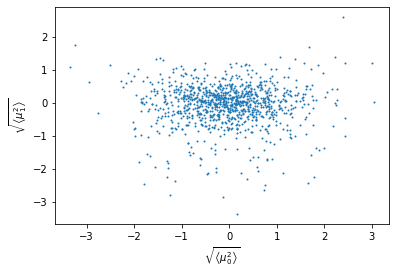

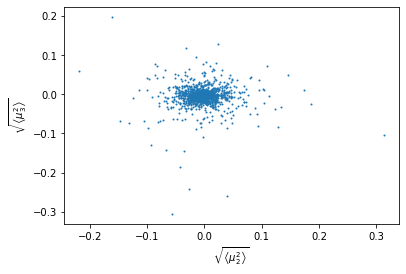

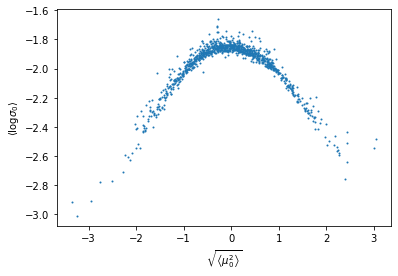

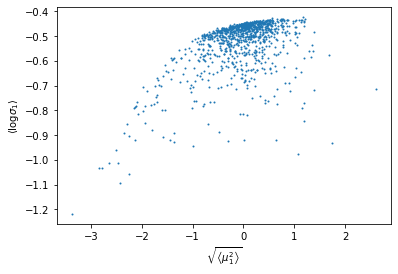

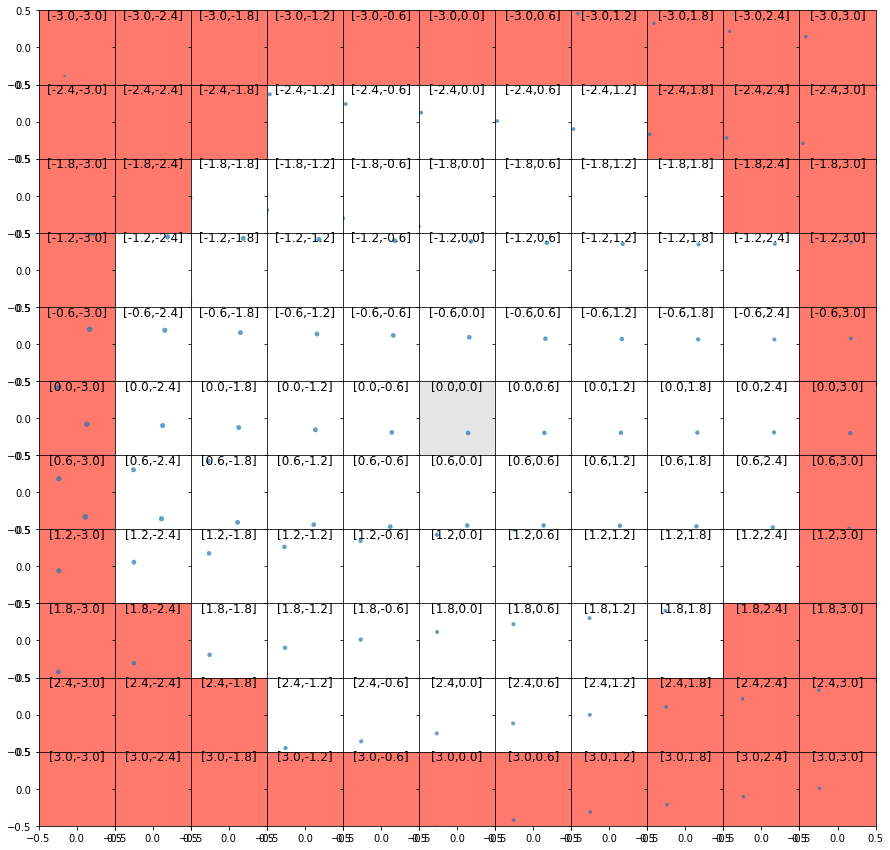

In [30]:
get_plot("model_weights_end_620_2.1e-01.hdf5")

epoch = 736
Beta = 0.1
Loss: 2.61e+01
Recon loss: 4.63e-01
KL loss: 3.0102544

KL divergences plot. x axis is ~ log(resolution) for resolution << 1


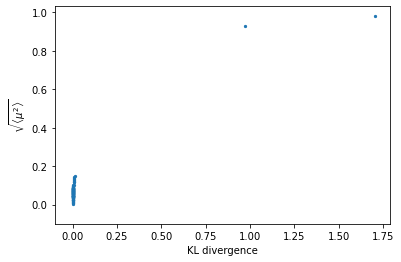

Jet sample plots. Left = original jet. Middle and right: two vae samples


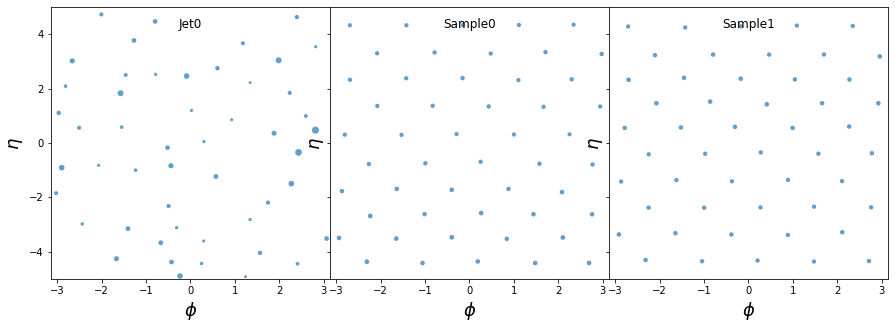

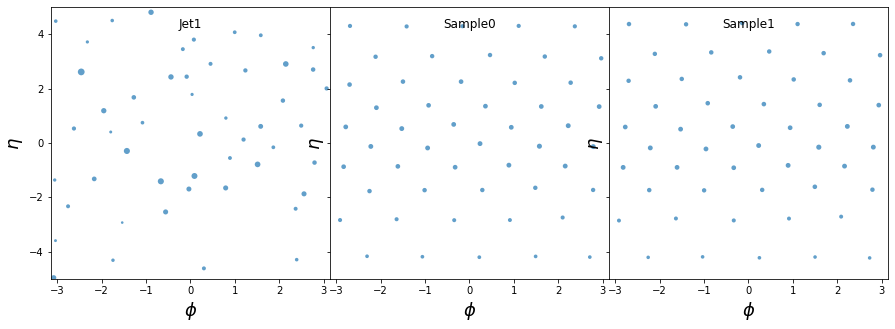

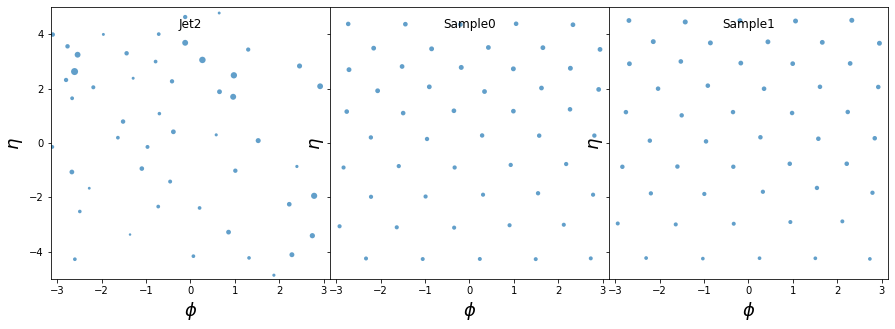

Latent space distributions in most important latent space directions


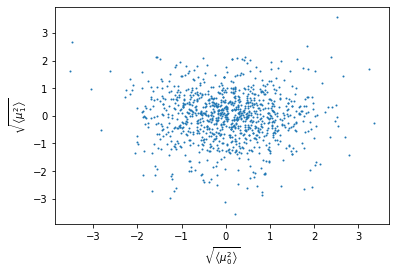

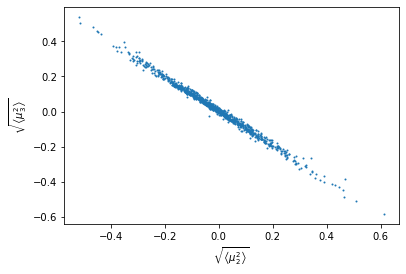

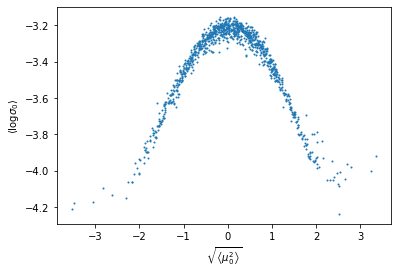

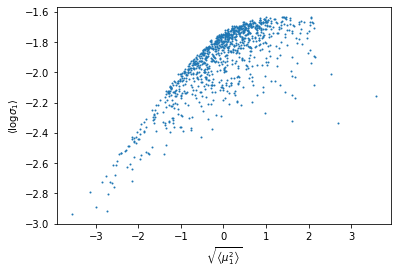

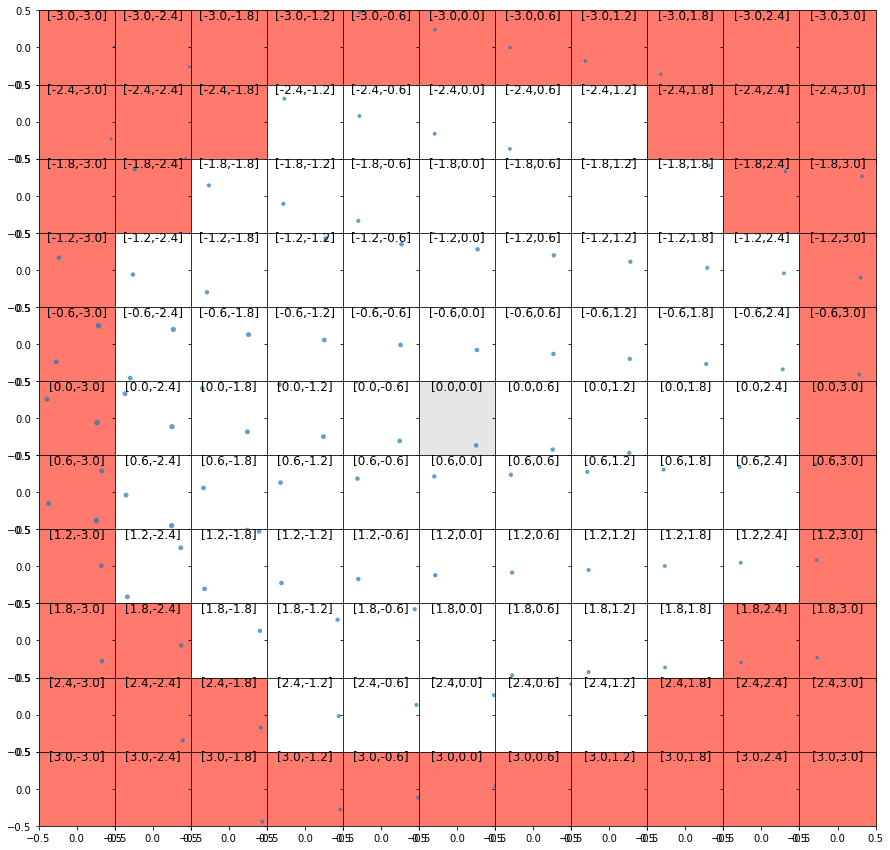

In [31]:
get_plot("model_weights_end_736_1.0e-01.hdf5")

epoch = 1823
Beta = 0.2
Loss: 7.99e+00
Recon loss: 5.36e-01
KL loss: 1.2844634

KL divergences plot. x axis is ~ log(resolution) for resolution << 1


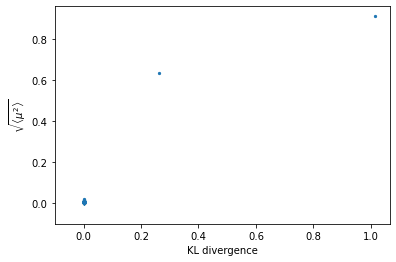

Jet sample plots. Left = original jet. Middle and right: two vae samples


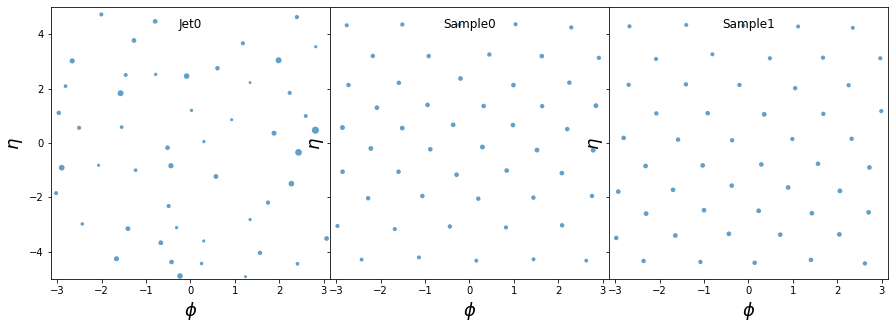

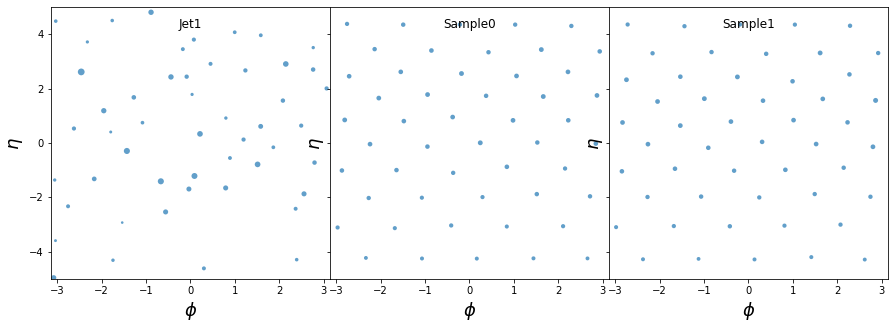

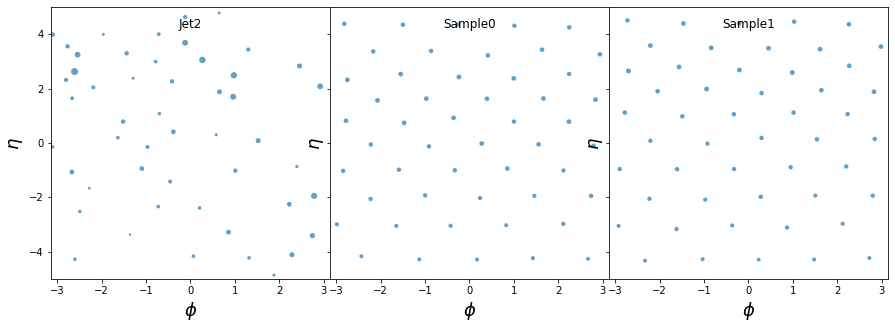

Latent space distributions in most important latent space directions


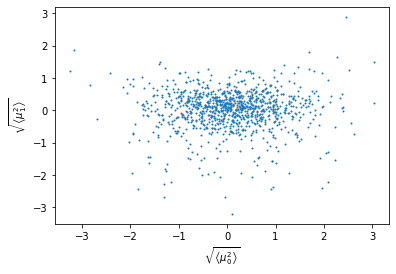

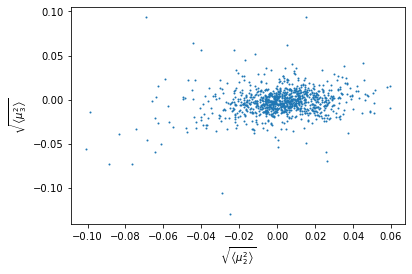

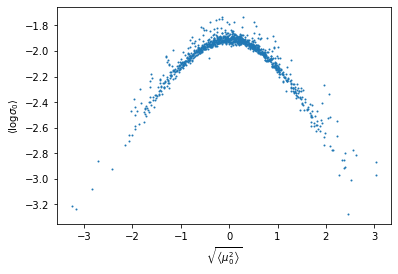

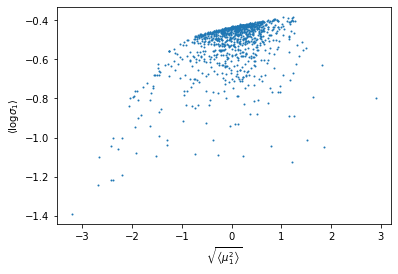

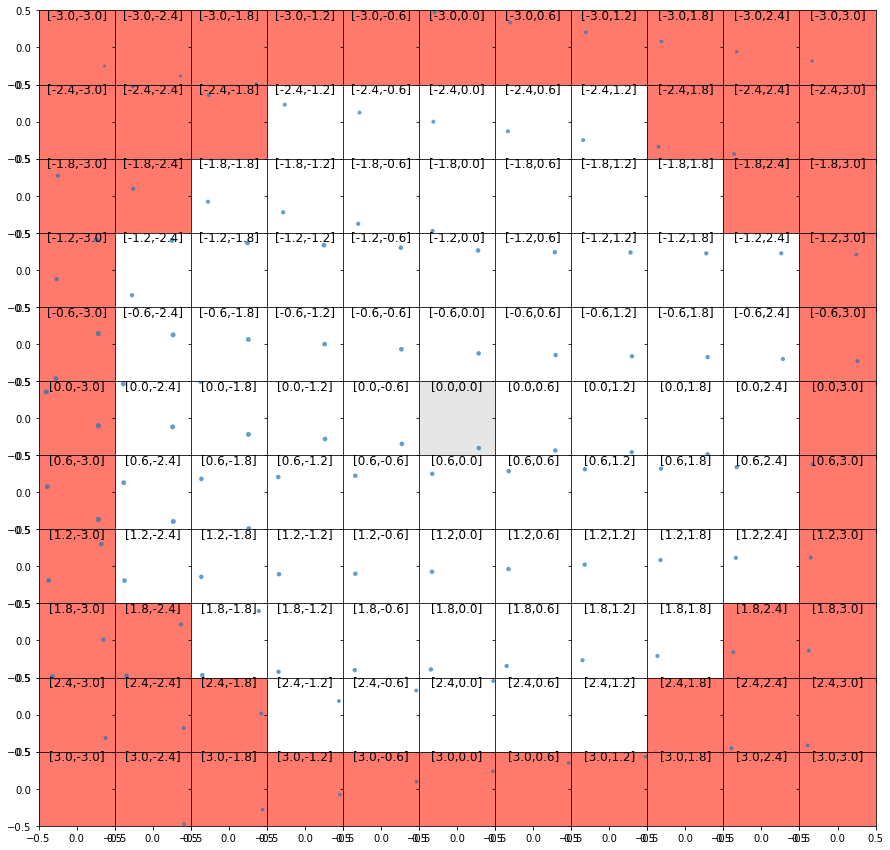

In [32]:
get_plot("model_weights_end_1823_2.0e-01.hdf5")

(array([ 6., 14.,  8.,  2.,  5.,  9.,  2.,  1.,  1.,  2.]),
 array([0.01019764, 0.01306539, 0.01593314, 0.01880089, 0.02166864,
        0.02453639, 0.02740414, 0.03027189, 0.03313964, 0.03600739,
        0.03887514]),
 <BarContainer object of 10 artists>)

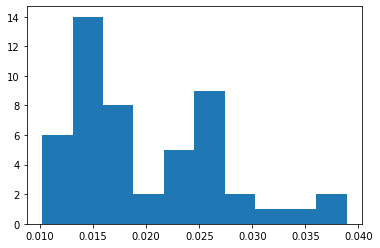

In [11]:
outjet = valid_y[1999,:,1:]
weights = valid_y[1999,:,0]
pts, etas, phis = get_clustered_pt_eta_phi(weights, outjet,R=0.02)
plt.hist(pts)

In [12]:
%ls

jet_plot/                   model_weights_902.hdf5
jet_plotepoch1803_beta0.1/  model_weights_922.hdf5
log.csv                     model_weights_942.hdf5
model_weights_1006.hdf5     model_weights_962.hdf5
model_weights_100.hdf5      model_weights_982.hdf5
model_weights_1026.hdf5     model_weights_end_1077_5.9e-03.hdf5
model_weights_1046.hdf5     model_weights_end_1171_2.9e-03.hdf5
model_weights_1066.hdf5     model_weights_end_1265_1.4e-03.hdf5
model_weights_1097.hdf5     model_weights_end_1348_7.0e-04.hdf5
model_weights_1117.hdf5     model_weights_end_1362_3.5e-04.hdf5
model_weights_1137.hdf5     model_weights_end_1389_1.7e-04.hdf5
model_weights_1157.hdf5     model_weights_end_1423_8.4e-05.hdf5
model_weights_1191.hdf5     model_weights_end_1529_4.1e-05.hdf5
model_weights_120.hdf5      model_weights_end_1555_2.0e-05.hdf5
model_weights_1211.hdf5     model_weights_end_1570_1.0e-05.hdf5
model_weights_1231.hdf5     model_weights_end_1599_2.0e-05.hdf5
model_weights_1251.hdf5     model_weights

epoch = 1788
Beta = 0.049
Loss: 7.93e+01
Recon loss: 2.91e-01
KL loss: 18.734566

KL divergences plot. x axis is ~ log(resolution) for resolution << 1


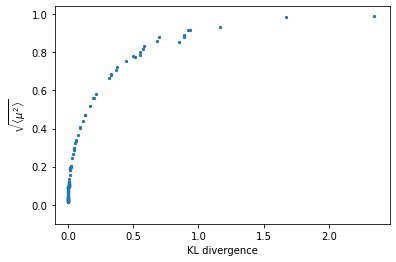

Jet sample plots. Left = original jet. Middle and right: two vae samples


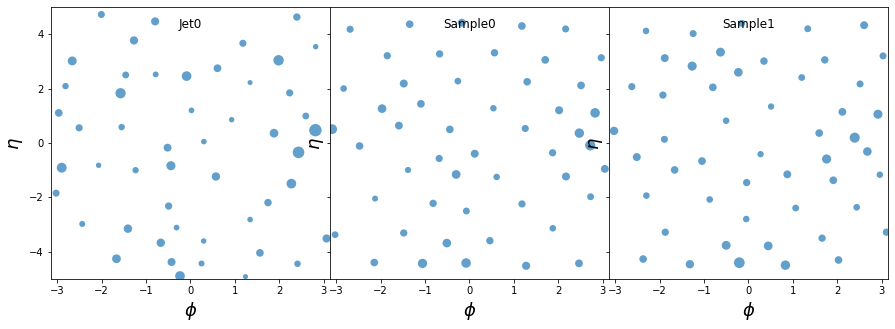

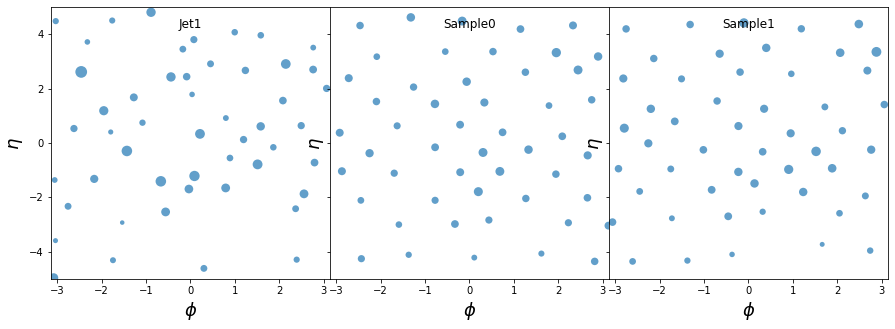

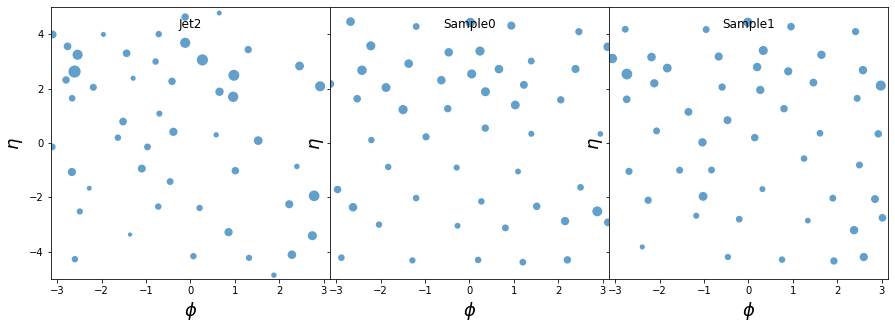

Latent space distributions in most important latent space directions


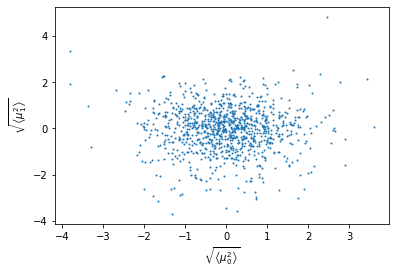

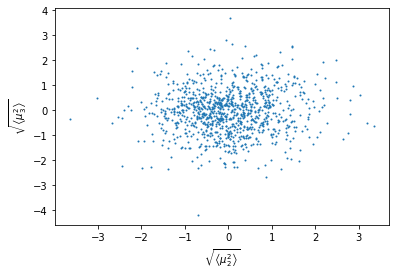

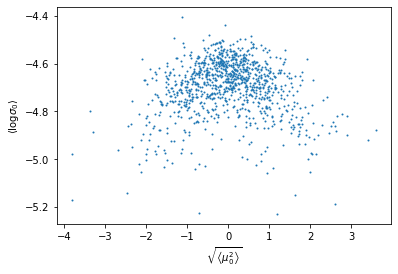

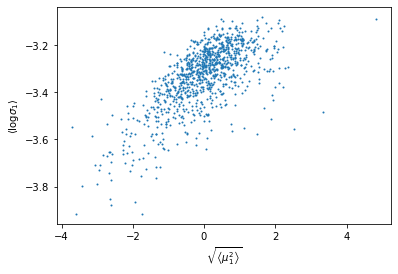

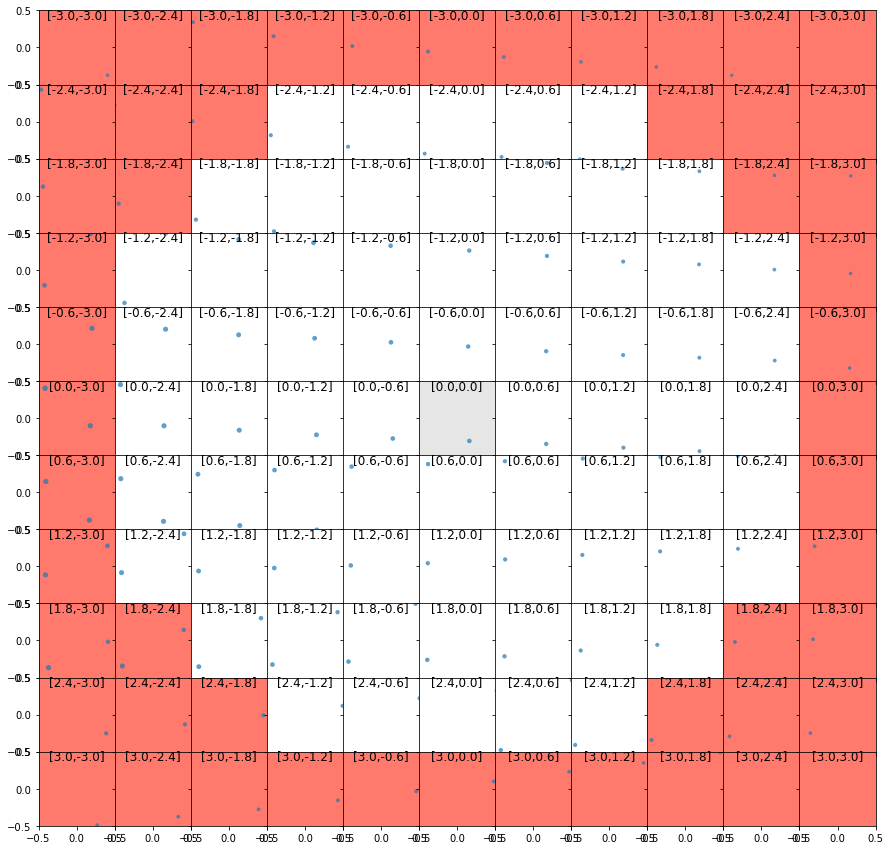

In [18]:
get_plot("model_weights_end_1788_4.9e-02.hdf5")

epoch = 1803
Beta = 0.1
Loss: 2.54e+01
Recon loss: 4.18e-01
KL loss: 4.5117736

KL divergences plot. x axis is ~ log(resolution) for resolution << 1


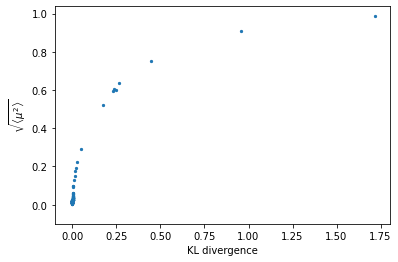

Jet sample plots. Left = original jet. Middle and right: two vae samples


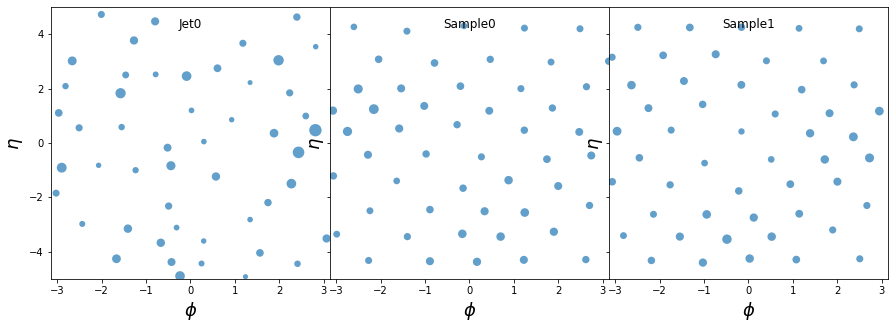

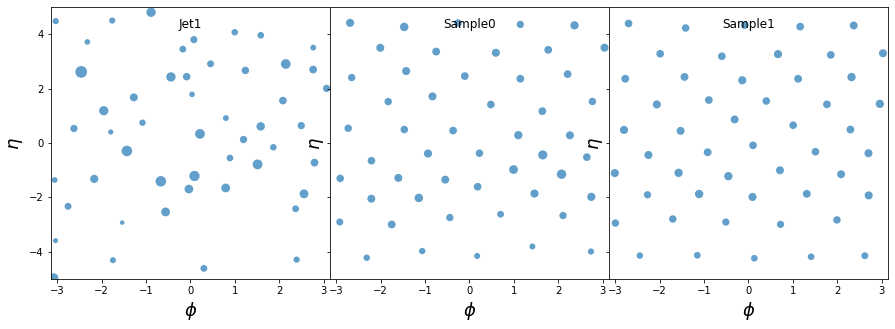

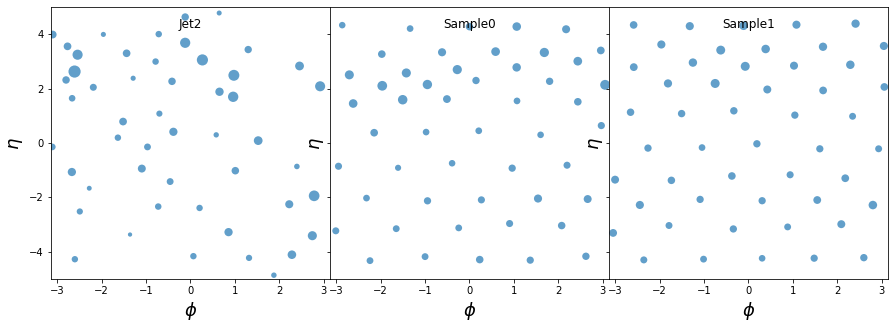

Latent space distributions in most important latent space directions


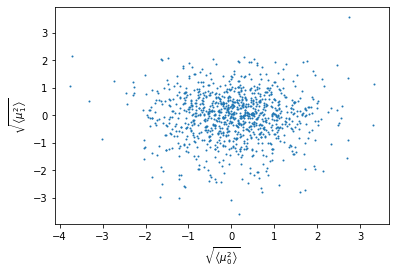

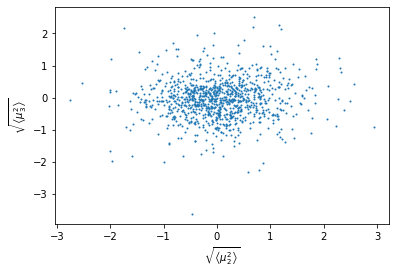

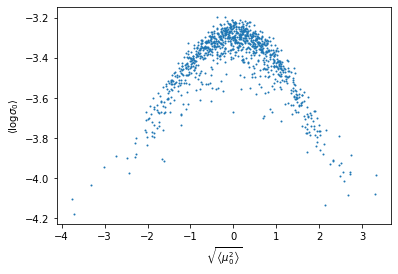

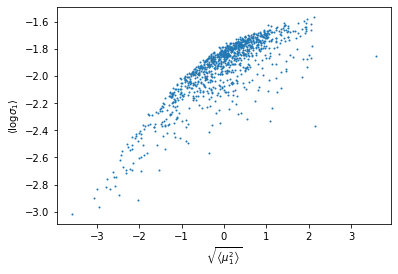

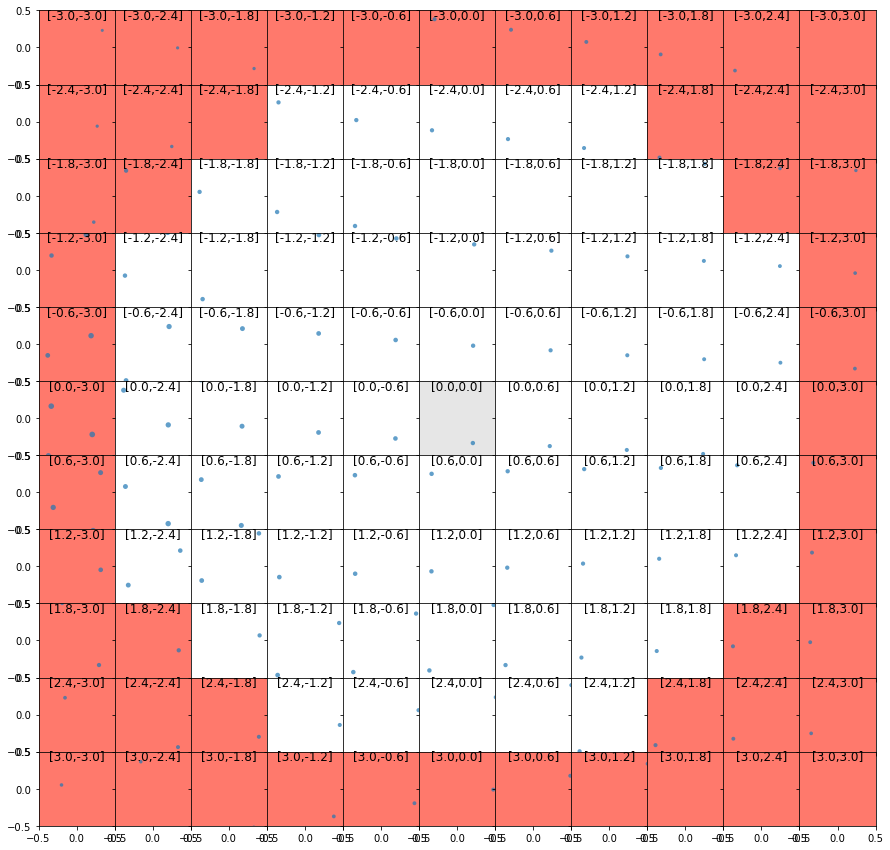

In [19]:
get_plot("model_weights_end_1803_1.0e-01.hdf5")

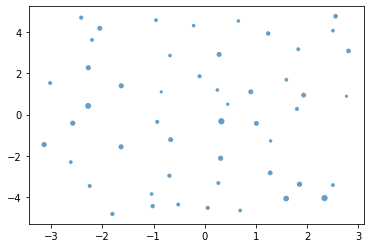

In [33]:
plt.scatter(phis, etas, s = pts*1000, alpha = 0.7,linewidths=0)

In [69]:
file = "model_weights_end_1803_1.0e-01.hdf5"
vae.load_weights(file)
beta = get_beta(file)
outs_array = [vae.predict(valid_x[:1000]) for j in range(3)]

In [73]:
outjet = outs_array[0][0][1,:,1:]
weights = outs_array[0][0][1,:,0]
pts, etas, phis = get_clustered_pt_eta_phi(weights, outjet,R=0.02)

(array([4., 3., 3., 5., 8., 6., 7., 6., 3., 5.]),
 array([0.01379526, 0.01497245, 0.01614965, 0.01732685, 0.01850404,
        0.01968124, 0.02085844, 0.02203563, 0.02321283, 0.02439003,
        0.02556722]),
 <BarContainer object of 10 artists>)

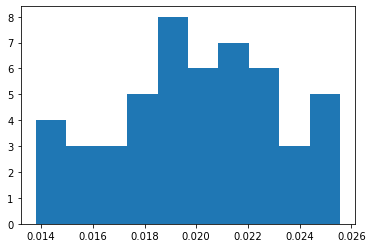

In [74]:
plt.hist(pts)

(array([ 5., 11., 12.,  6.,  5.,  4.,  3.,  3.,  0.,  1.]),
 array([0.00682092, 0.01073192, 0.01464292, 0.01855392, 0.02246492,
        0.02637591, 0.03028691, 0.03419791, 0.03810891, 0.04201991,
        0.04593091]),
 <BarContainer object of 10 artists>)

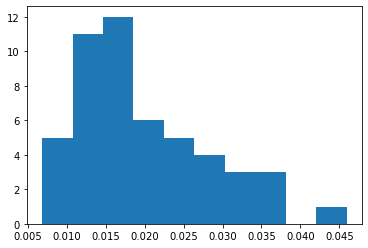

In [75]:
outjet = valid_y[1,:,1:]
weights = valid_y[1,:,0]
pts, etas, phis = get_clustered_pt_eta_phi(weights, outjet,R=0.02)
plt.hist(pts)